In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    # If you are using GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

## Project configuration

In [3]:
config = {
    'ROOT_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
    'TEST_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    'MODELS_DIR': '/kaggle/working/',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 100,
    'PATIENCE': 9,
    'WARMUP_EPOCHS': 5,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 3e-4,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 4,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

## Utility functions and variables

In [4]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# read the directory and get all images and their corresponding labels
def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels

# custom Dataset class
class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# to get DataLoaders from custom Dataset
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [6]:
# cosine annealing adjusting learning rate
def adjust_learning_rate(optimizer, epoch, warmup=True, warmup_ep=config['WARMUP_EPOCHS'], enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
# in order to evaluate the model on metrics such as accuracy and f1
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [8]:
# plot training process in graphs
def save_graphs(train, val, graph_type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Test {graph_type}")
    plt.plot(val, label="validation")
    plt.plot(train, label="train")
    plt.xlabel("Epoch")
    plt.ylabel(graph_type)
    plt.legend()
    plt.savefig(f'{graph_type}.png')

In [9]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    # will be used to calculate metrics
    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    # get metrics
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    # will be used to calculate metrics
    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    # get metrics
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [11]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], graph_type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], graph_type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], graph_type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

## Our implementation of ResNet50 and ResNet101

In [12]:
# Block for ResNet50 and ResNet101 architectures
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channels
        :param identity_downsample: Conv layer to downsample image in case of different input and output channels
        :param stride: stride
        """
        super().__init__()
        self.identity_downsample = identity_downsample

        # every block in ResNet50 or deeper increases the number of in_channels by 4
        self.expansion = 4
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels * self.expansion),
            nn.ReLU()
        )
    
    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # if the input and output channels are different, then downsample (with no activation, hence identity) the input image
        if self.identity_downsample:
            identity = self.identity_downsample(identity)
        
        # add the identity (input image) to the output of the block
        x = x + identity
        x = F.relu(x)
        return x

# ResNet50 and ResNet101 architectures
class MyResNet(nn.Module):
    def __init__(self, num_layers, in_channels, out_classes):
        """
        :param num_layers: number of layers in the architecture (ResNet)
        :param in_channels: number of input image channels
        :param out_classes: number of output classes
        """
        assert num_layers in [50, 101], 'unknown architecture'

        super().__init__()

        # how many times to reuse the same block in the architecture
        if num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            raise NotImplementedError('unknown architecture')
        
        self.in_channels = 64

        # according to the paper, the first layer is 7x7 conv with stride 2 and padding 3
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(layers[0], 64, stride=1)
        self.layer2 = self._make_layer(layers[1], 128, stride=2)
        self.layer3 = self._make_layer(layers[2], 256, stride=2)
        self.layer4 = self._make_layer(layers[3], 512, stride=2)

        # according to the paper, the last layer is avgpool with output size 1x1
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512 * 4, out_classes)
    
    def _make_layer(self, num_residual_blocks, in_channels, stride):
        """
        :param num_residual_blocks: how many times to reuse the same block in the architecture
        :param in_channels: number of input channels, output channels are 4 times larger
        :param stride: stride
        :return: layers of residual blocks
        """
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != in_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, in_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(in_channels * 4)
            )
        
        # perform the first residual block
        layers.append(Block(self.in_channels, in_channels, identity_downsample, stride))
        self.in_channels = in_channels * 4

        # perform the rest of the residual blocks
        for i in range(num_residual_blocks - 1):
            layers.append(Block(self.in_channels, in_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        # first 7x7 conv layer
        x = self.conv1(x)
        x = self.maxpool(x)

        # ResNet layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # last avgpool layer plus fully connected layer
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x


# in this project we have 10 classes to predict, so out_classes=10
def ResNet50(in_channels=3, out_classes=10):
    return MyResNet(50, in_channels, out_classes=out_classes)


# in this project we have 10 classes to predict, so out_classes=10
def ResNet101(in_channels=3, out_classes=10):
    return MyResNet(101, in_channels, out_classes=out_classes)

## Preparing for training

In [13]:
model = ResNet50()
model_name = 'resnet50'
model = model.to(config['DEVICE'])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

## Training

Training: 100%|██████████| 281/281 [03:29<00:00,  1.34it/s]


Epoch 1 | Train Loss: 2.262424326452072 | Accuracy: 0.16043257706672612 | Precision: 0.1565140267940971 | Recall: 0.16043257706672612 | F1: 0.1477786066678615


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.59it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 2.2532862374480342 | Accuracy: 0.1979933110367893 | Precision: 0.257372328373362 | Recall: 0.1979933110367893 | F1: 0.1267723078936465
Saving best model at epoch 1...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 2 | Train Loss: 1.8179699398868874 | Accuracy: 0.3510229109760856 | Precision: 0.3375815362622401 | Recall: 0.3510229109760856 | F1: 0.331872302020726


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.76it/s]


	Validation Loss: 1.6038072260332779 | Accuracy: 0.4131549609810479 | Precision: 0.4969355734530686 | Recall: 0.4131549609810479 | F1: 0.3477313229287008
Saving best model at epoch 2...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 3 | Train Loss: 1.1050520276259697 | Accuracy: 0.6105134065444004 | Precision: 0.6062101625597456 | Recall: 0.6105134065444004 | F1: 0.6061056465562589


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.64it/s]


	Validation Loss: 1.1435802788801597 | Accuracy: 0.5759197324414715 | Precision: 0.7115860126940621 | Recall: 0.5759197324414715 | F1: 0.5329885447483451
Saving best model at epoch 3...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 4 | Train Loss: 0.5723653575173476 | Accuracy: 0.8129215675344222 | Precision: 0.8121424573126343 | Recall: 0.8129215675344222 | F1: 0.8123099388857495


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.58it/s]


	Validation Loss: 0.5449450624660707 | Accuracy: 0.8171683389074693 | Precision: 0.8491120850526583 | Recall: 0.8171683389074693 | F1: 0.8208772969319454
Saving best model at epoch 4...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 5 | Train Loss: 0.3853968145107035 | Accuracy: 0.876693238196109 | Precision: 0.8763501148687105 | Recall: 0.876693238196109 | F1: 0.8764486191841382


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.64it/s]


	Validation Loss: 0.40510132698945595 | Accuracy: 0.867335562987737 | Precision: 0.8857546936622663 | Recall: 0.867335562987737 | F1: 0.8688617693943282
Saving best model at epoch 5...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 6 | Train Loss: 0.21198460153466442 | Accuracy: 0.932493450025085 | Precision: 0.9324368378712742 | Recall: 0.932493450025085 | F1: 0.9324160097792371


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.83it/s]


	Validation Loss: 0.5910338685965874 | Accuracy: 0.8278706800445931 | Precision: 0.8793380578110991 | Recall: 0.8278706800445931 | F1: 0.81896073918616


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 7 | Train Loss: 0.1620913282620101 | Accuracy: 0.9498857238419087 | Precision: 0.9498743944809622 | Recall: 0.9498857238419087 | F1: 0.9498669630083715


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.84it/s]


	Validation Loss: 0.2479895983468479 | Accuracy: 0.9219620958751393 | Precision: 0.9274004240104664 | Recall: 0.9219620958751393 | F1: 0.9206732849786726
Saving best model at epoch 7...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 8 | Train Loss: 0.11258889746013698 | Accuracy: 0.9649367300295446 | Precision: 0.964889195534558 | Recall: 0.9649367300295446 | F1: 0.9648977533767154


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.73it/s]


	Validation Loss: 0.8171823175860123 | Accuracy: 0.7591973244147158 | Precision: 0.9020444178801196 | Recall: 0.7591973244147158 | F1: 0.7858584438180702


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 9 | Train Loss: 0.09892590578274264 | Accuracy: 0.9700094765594515 | Precision: 0.9699819193323479 | Recall: 0.9700094765594515 | F1: 0.9699884069574914


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.67it/s]


	Validation Loss: 0.11661887486320986 | Accuracy: 0.9652173913043478 | Precision: 0.9656761755474261 | Recall: 0.9652173913043478 | F1: 0.9649966213295412
Saving best model at epoch 9...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 10 | Train Loss: 0.0908283425521543 | Accuracy: 0.9712915993087686 | Precision: 0.9713136099297582 | Recall: 0.9712915993087686 | F1: 0.9712950216421593


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.59it/s]


	Validation Loss: 0.1604417375957882 | Accuracy: 0.9591973244147157 | Precision: 0.961521198966243 | Recall: 0.9591973244147157 | F1: 0.9590092964112751


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 11 | Train Loss: 0.08331596827485807 | Accuracy: 0.9750822230893584 | Precision: 0.9750699366246866 | Recall: 0.9750822230893584 | F1: 0.9750688916330522


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.74it/s]


	Validation Loss: 0.25549083906160275 | Accuracy: 0.9250836120401338 | Precision: 0.9405121519263565 | Recall: 0.9250836120401338 | F1: 0.925399258059345


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 12 | Train Loss: 0.07230711242787248 | Accuracy: 0.9772005128490997 | Precision: 0.9772279343927752 | Recall: 0.9772005128490997 | F1: 0.9772048829877896


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.60it/s]


	Validation Loss: 0.1273959743188576 | Accuracy: 0.9594202898550724 | Precision: 0.9625311915335617 | Recall: 0.9594202898550724 | F1: 0.959466947027904


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 13 | Train Loss: 0.05534364236684457 | Accuracy: 0.9824962372484531 | Precision: 0.9825099742081709 | Recall: 0.9824962372484531 | F1: 0.9824930378993103


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.70it/s]


	Validation Loss: 0.432547342084663 | Accuracy: 0.8800445930880714 | Precision: 0.9294788177119371 | Recall: 0.8800445930880714 | F1: 0.8900202717658814


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 14 | Train Loss: 0.0731317529693458 | Accuracy: 0.9769217905122917 | Precision: 0.9769224818481191 | Recall: 0.9769217905122917 | F1: 0.9769178837629666


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.61it/s]


	Validation Loss: 0.06557817890925306 | Accuracy: 0.9783723522853958 | Precision: 0.9787783484801518 | Recall: 0.9783723522853958 | F1: 0.9784229278004927
Saving best model at epoch 14...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 15 | Train Loss: 0.06064820350512359 | Accuracy: 0.981492836835944 | Precision: 0.9814856161921359 | Recall: 0.981492836835944 | F1: 0.9814840876026086


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.62it/s]


	Validation Loss: 0.08537358999855711 | Accuracy: 0.9741360089186176 | Precision: 0.9751853184654432 | Recall: 0.9741360089186176 | F1: 0.9742300411896213


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 16 | Train Loss: 0.0646271789214471 | Accuracy: 0.9808239032276047 | Precision: 0.9808287209995994 | Recall: 0.9808239032276047 | F1: 0.980825691218558


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.64it/s]


	Validation Loss: 0.5221436525314627 | Accuracy: 0.8722408026755852 | Precision: 0.9264205902536515 | Recall: 0.8722408026755852 | F1: 0.8779404386239553


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 17 | Train Loss: 0.05744706896660697 | Accuracy: 0.9819945370421985 | Precision: 0.9820146642764656 | Recall: 0.9819945370421985 | F1: 0.9819991945074219


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.61it/s]


	Validation Loss: 0.14456811771583808 | Accuracy: 0.959866220735786 | Precision: 0.9664076749429296 | Recall: 0.959866220735786 | F1: 0.9609382399171513


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 18 | Train Loss: 0.04854487616476003 | Accuracy: 0.9852834606165338 | Precision: 0.9852787400792985 | Recall: 0.9852834606165338 | F1: 0.9852800839031088


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.53it/s]


	Validation Loss: 0.18798392749732543 | Accuracy: 0.9538461538461539 | Precision: 0.9565252693277192 | Recall: 0.9538461538461539 | F1: 0.9527079065466635


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 19 | Train Loss: 0.04112342328124836 | Accuracy: 0.9863983499637661 | Precision: 0.9863944696394755 | Recall: 0.9863983499637661 | F1: 0.9863931805580329


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.45it/s]


	Validation Loss: 0.04794728864495918 | Accuracy: 0.9830546265328874 | Precision: 0.9835341007096798 | Recall: 0.9830546265328874 | F1: 0.983021964579328
Saving best model at epoch 19...


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 20 | Train Loss: 0.04874895162486017 | Accuracy: 0.9848375048776409 | Precision: 0.9848339199375514 | Recall: 0.9848375048776409 | F1: 0.9848338640848068


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.48it/s]


	Validation Loss: 0.07131689255663627 | Accuracy: 0.9801560758082497 | Precision: 0.9805058654211557 | Recall: 0.9801560758082497 | F1: 0.9800940275664533


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 21 | Train Loss: 0.05154025088912837 | Accuracy: 0.9830536819220692 | Precision: 0.9830512718167518 | Recall: 0.9830536819220692 | F1: 0.9830498816272081


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.64it/s]


	Validation Loss: 0.06627405173486282 | Accuracy: 0.9819397993311036 | Precision: 0.9821452326962642 | Recall: 0.9819397993311036 | F1: 0.9818807402288506


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 22 | Train Loss: 0.04159269013874617 | Accuracy: 0.9863983499637661 | Precision: 0.9864001973602439 | Recall: 0.9863983499637661 | F1: 0.9863963012678195


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.86it/s]


	Validation Loss: 0.05609441697794262 | Accuracy: 0.9855072463768116 | Precision: 0.9856662295655894 | Recall: 0.9855072463768116 | F1: 0.9855243655905854


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 23 | Train Loss: 0.04277027968410071 | Accuracy: 0.9865098388984893 | Precision: 0.9865003387509287 | Recall: 0.9865098388984893 | F1: 0.9865037127132291


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.82it/s]


	Validation Loss: 0.06020072188628444 | Accuracy: 0.9835005574136009 | Precision: 0.984049655818309 | Recall: 0.9835005574136009 | F1: 0.9834643819810638


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 24 | Train Loss: 0.034242442316248074 | Accuracy: 0.98929706226657 | Precision: 0.989299026742725 | Recall: 0.98929706226657 | F1: 0.9892970415325413


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.58it/s]


	Validation Loss: 0.0758684091491323 | Accuracy: 0.9734671125975474 | Precision: 0.9763517586524392 | Recall: 0.9734671125975474 | F1: 0.973660407317985


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 25 | Train Loss: 0.04509033895142416 | Accuracy: 0.9856179274207035 | Precision: 0.9856365757370118 | Recall: 0.9856179274207035 | F1: 0.9856235954445879


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.50it/s]


	Validation Loss: 0.04738726552156076 | Accuracy: 0.9841694537346711 | Precision: 0.9846277439866382 | Recall: 0.9841694537346711 | F1: 0.9841484281438356
Saving best model at epoch 25...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 26 | Train Loss: 0.025871237852814477 | Accuracy: 0.9920842856346508 | Precision: 0.992090756971986 | Recall: 0.9920842856346508 | F1: 0.9920859689854375


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.59it/s]


	Validation Loss: 0.07459400882157431 | Accuracy: 0.9777034559643255 | Precision: 0.9781670114118763 | Recall: 0.9777034559643255 | F1: 0.9774012863390725


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 27 | Train Loss: 0.028785564760003053 | Accuracy: 0.9906349294832488 | Precision: 0.990632123141441 | Recall: 0.9906349294832488 | F1: 0.9906316577110341


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.49it/s]


	Validation Loss: 0.050323859739287845 | Accuracy: 0.9875139353400223 | Precision: 0.9875951176816048 | Recall: 0.9875139353400223 | F1: 0.987491249428104


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 28 | Train Loss: 0.034093964594193435 | Accuracy: 0.9895200401360165 | Precision: 0.9895234543883257 | Recall: 0.9895200401360165 | F1: 0.9895211738468979


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.79it/s]


	Validation Loss: 0.09008135253393 | Accuracy: 0.9698996655518395 | Precision: 0.9728527370204924 | Recall: 0.9698996655518395 | F1: 0.9702491736148106


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 29 | Train Loss: 0.03208357078111084 | Accuracy: 0.9900217403422711 | Precision: 0.9900174106578118 | Recall: 0.9900217403422711 | F1: 0.9900186387925124


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.55it/s]


	Validation Loss: 0.05606907280161977 | Accuracy: 0.9846153846153847 | Precision: 0.9848752432654202 | Recall: 0.9846153846153847 | F1: 0.9845808709663184


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 30 | Train Loss: 0.02710457958216411 | Accuracy: 0.9916383298957578 | Precision: 0.9916407930540003 | Recall: 0.9916383298957578 | F1: 0.9916387089324731


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.86it/s]


	Validation Loss: 0.060746062842105895 | Accuracy: 0.9830546265328874 | Precision: 0.9837131829319027 | Recall: 0.9830546265328874 | F1: 0.9831502806846706


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 31 | Train Loss: 0.035841515985109554 | Accuracy: 0.9889068509950387 | Precision: 0.9889084878120711 | Recall: 0.9889068509950387 | F1: 0.9889073139163848


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.54it/s]


	Validation Loss: 0.0829566108640021 | Accuracy: 0.978149386845039 | Precision: 0.9789335116239336 | Recall: 0.978149386845039 | F1: 0.9781840863382438


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 32 | Train Loss: 0.022181482160972675 | Accuracy: 0.993645130720776 | Precision: 0.9936450972203793 | Recall: 0.993645130720776 | F1: 0.9936445226048345


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.54it/s]


	Validation Loss: 0.0360396122494319 | Accuracy: 0.9904124860646599 | Precision: 0.9904686387801569 | Recall: 0.9904124860646599 | F1: 0.9903802727751361
Saving best model at epoch 32...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 33 | Train Loss: 0.025983704921192476 | Accuracy: 0.9919727966999276 | Precision: 0.9919713785146325 | Recall: 0.9919727966999276 | F1: 0.9919711376466804


Validating: 100%|██████████| 71/71 [00:11<00:00,  5.94it/s]


	Validation Loss: 0.044873499358646755 | Accuracy: 0.987736900780379 | Precision: 0.9879543688158079 | Recall: 0.987736900780379 | F1: 0.9876627195429055


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 34 | Train Loss: 0.026114368140774124 | Accuracy: 0.9917498188304811 | Precision: 0.9917516204969784 | Recall: 0.9917498188304811 | F1: 0.9917502660044848


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.91it/s]


	Validation Loss: 0.06977022879652049 | Accuracy: 0.9814938684503902 | Precision: 0.9821583133311852 | Recall: 0.9814938684503902 | F1: 0.9815001851969193


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 35 | Train Loss: 0.026995539379466055 | Accuracy: 0.9921400301020123 | Precision: 0.9921453224433489 | Recall: 0.9921400301020123 | F1: 0.9921419242146898


Validating: 100%|██████████| 71/71 [00:11<00:00,  5.96it/s]


	Validation Loss: 0.08695503668597257 | Accuracy: 0.9725752508361204 | Precision: 0.973864608352333 | Recall: 0.9725752508361204 | F1: 0.9725667792100176


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 36 | Train Loss: 0.019490327587366945 | Accuracy: 0.9937566196554992 | Precision: 0.993756049717899 | Recall: 0.9937566196554992 | F1: 0.9937549746286223


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.56it/s]


	Validation Loss: 0.05594415654687368 | Accuracy: 0.9861761426978818 | Precision: 0.9865716761439396 | Recall: 0.9861761426978818 | F1: 0.986133264260652


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 37 | Train Loss: 0.02694580107775071 | Accuracy: 0.9915268409610346 | Precision: 0.9915280431329809 | Recall: 0.9915268409610346 | F1: 0.9915267449704234


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.54it/s]


	Validation Loss: 0.08083049746387651 | Accuracy: 0.9750278706800446 | Precision: 0.975969451544213 | Recall: 0.9750278706800446 | F1: 0.9749475037817068


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 38 | Train Loss: 0.02174807932920542 | Accuracy: 0.9934778973186911 | Precision: 0.993478659860398 | Recall: 0.9934778973186911 | F1: 0.9934779767273612


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.89it/s]


	Validation Loss: 0.031884542733806344 | Accuracy: 0.9919732441471572 | Precision: 0.9920679228404036 | Recall: 0.9919732441471572 | F1: 0.9919790273448857
Saving best model at epoch 38...


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 39 | Train Loss: 0.017959341981027315 | Accuracy: 0.9935893862534143 | Precision: 0.9935930466479918 | Recall: 0.9935893862534143 | F1: 0.9935902035543536


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.34it/s]


	Validation Loss: 0.035404247868786445 | Accuracy: 0.989520624303233 | Precision: 0.9896460960238845 | Recall: 0.989520624303233 | F1: 0.9894924816363111


Training: 100%|██████████| 281/281 [03:24<00:00,  1.37it/s]


Epoch 40 | Train Loss: 0.015370503652739766 | Accuracy: 0.9952059758069012 | Precision: 0.9952050459645684 | Recall: 0.9952059758069012 | F1: 0.995205233274389


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.69it/s]


	Validation Loss: 0.02074857696302196 | Accuracy: 0.9953177257525083 | Precision: 0.9953532541836349 | Recall: 0.9953177257525083 | F1: 0.9953185051147009
Saving best model at epoch 40...


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 41 | Train Loss: 0.015967193164075955 | Accuracy: 0.9954846981437092 | Precision: 0.9954860091287059 | Recall: 0.9954846981437092 | F1: 0.9954846651259481


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.41it/s]


	Validation Loss: 0.03183747634199828 | Accuracy: 0.9906354515050168 | Precision: 0.9907593288535014 | Recall: 0.9906354515050168 | F1: 0.9906451109562509


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 42 | Train Loss: 0.018613261710763312 | Accuracy: 0.9941468309270305 | Precision: 0.9941437571900547 | Recall: 0.9941468309270305 | F1: 0.9941443411611965


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


	Validation Loss: 0.04476802864621892 | Accuracy: 0.9875139353400223 | Precision: 0.9877441012238539 | Recall: 0.9875139353400223 | F1: 0.9875647564734434


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 43 | Train Loss: 0.014108848175084884 | Accuracy: 0.9959863983499637 | Precision: 0.9959865171402142 | Recall: 0.9959863983499637 | F1: 0.99598629374348


Validating: 100%|██████████| 71/71 [00:11<00:00,  5.93it/s]


	Validation Loss: 0.022295310391456668 | Accuracy: 0.9933110367892977 | Precision: 0.9933558123036289 | Recall: 0.9933110367892977 | F1: 0.9933139361978476


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 44 | Train Loss: 0.01563924499244671 | Accuracy: 0.995373209208986 | Precision: 0.995372025964934 | Recall: 0.995373209208986 | F1: 0.9953720296923407


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.81it/s]


	Validation Loss: 0.019496343470167068 | Accuracy: 0.9957636566332219 | Precision: 0.9957764584631612 | Recall: 0.9957636566332219 | F1: 0.9957617281929466
Saving best model at epoch 44...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 45 | Train Loss: 0.006163552589569526 | Accuracy: 0.9982161770444283 | Precision: 0.9982167982142813 | Recall: 0.9982161770444283 | F1: 0.9982163790249945


Validating: 100%|██████████| 71/71 [00:11<00:00,  5.95it/s]


	Validation Loss: 0.022578188787750624 | Accuracy: 0.9942028985507246 | Precision: 0.9942294067377456 | Recall: 0.9942028985507246 | F1: 0.9942013904716891


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 46 | Train Loss: 0.010552432285685977 | Accuracy: 0.9965438430235799 | Precision: 0.9965455600555946 | Recall: 0.9965438430235799 | F1: 0.9965445076445764


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.66it/s]


	Validation Loss: 0.12284705296657245 | Accuracy: 0.9649944258639911 | Precision: 0.9687306851036788 | Recall: 0.9649944258639911 | F1: 0.9652019488464008


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 47 | Train Loss: 0.016066908133263846 | Accuracy: 0.9950944868721779 | Precision: 0.9950967938488138 | Recall: 0.9950944868721779 | F1: 0.9950950228581703


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.67it/s]


	Validation Loss: 0.021505622380547568 | Accuracy: 0.9953177257525083 | Precision: 0.9953809194469941 | Recall: 0.9953177257525083 | F1: 0.9953301175303396


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 48 | Train Loss: 0.007702711164054181 | Accuracy: 0.9976587323708122 | Precision: 0.9976592826629987 | Recall: 0.9976587323708122 | F1: 0.9976589193265715


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.65it/s]


	Validation Loss: 0.02253304087433105 | Accuracy: 0.9937569676700111 | Precision: 0.9939152225425554 | Recall: 0.9937569676700111 | F1: 0.9937669284696045


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 49 | Train Loss: 0.009623718968952187 | Accuracy: 0.9968225653603879 | Precision: 0.9968230921784957 | Recall: 0.9968225653603879 | F1: 0.9968226130228663


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.70it/s]


	Validation Loss: 0.04143628265879209 | Accuracy: 0.9881828316610926 | Precision: 0.9889020020868015 | Recall: 0.9881828316610926 | F1: 0.988300574858008


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 50 | Train Loss: 0.008035380108895844 | Accuracy: 0.9972685210992809 | Precision: 0.99726968744715 | Recall: 0.9972685210992809 | F1: 0.9972687274442578


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.48it/s]


	Validation Loss: 0.020668951272839454 | Accuracy: 0.9959866220735786 | Precision: 0.9960142773516287 | Recall: 0.9959866220735786 | F1: 0.9959898027816404


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 51 | Train Loss: 0.010128761405898738 | Accuracy: 0.9968783098277496 | Precision: 0.9968779969811843 | Recall: 0.9968783098277496 | F1: 0.9968779330181807


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.67it/s]


	Validation Loss: 0.02606336890332873 | Accuracy: 0.9933110367892977 | Precision: 0.9933789483579104 | Recall: 0.9933110367892977 | F1: 0.9933041394489626


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 52 | Train Loss: 0.014956276144244496 | Accuracy: 0.9955961870784324 | Precision: 0.9955986733356016 | Recall: 0.9955961870784324 | F1: 0.9955965054209318


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.62it/s]


	Validation Loss: 0.022950923462803346 | Accuracy: 0.9939799331103679 | Precision: 0.9939828017574642 | Recall: 0.9939799331103679 | F1: 0.9939791852269259


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 53 | Train Loss: 0.006852939397089798 | Accuracy: 0.9977702213055354 | Precision: 0.9977720237917641 | Recall: 0.9977702213055354 | F1: 0.997770668454583


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.32it/s]


	Validation Loss: 0.017277851782944734 | Accuracy: 0.9964325529542921 | Precision: 0.9964507869820856 | Recall: 0.9964325529542921 | F1: 0.9964353027887505
Saving best model at epoch 53...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 54 | Train Loss: 0.00443746900236227 | Accuracy: 0.9988851106527677 | Precision: 0.9988857352448878 | Recall: 0.9988851106527677 | F1: 0.9988851353662209


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.77it/s]


	Validation Loss: 0.018164726404854302 | Accuracy: 0.9968784838350055 | Precision: 0.9968838654317275 | Recall: 0.9968784838350055 | F1: 0.9968782410889002


Training: 100%|██████████| 281/281 [03:24<00:00,  1.37it/s]


Epoch 55 | Train Loss: 0.0018395480585299134 | Accuracy: 0.999554044261107 | Precision: 0.999554044261107 | Recall: 0.999554044261107 | F1: 0.999554044261107


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.74it/s]


	Validation Loss: 0.015417708705300215 | Accuracy: 0.9966555183946488 | Precision: 0.996662661005212 | Recall: 0.9966555183946488 | F1: 0.9966548559726459
Saving best model at epoch 55...


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 56 | Train Loss: 0.004838609514214029 | Accuracy: 0.9989408551201293 | Precision: 0.9989411908086014 | Recall: 0.9989408551201293 | F1: 0.9989408880049666


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.56it/s]


	Validation Loss: 0.02097222837554794 | Accuracy: 0.9948717948717949 | Precision: 0.9948855579068748 | Recall: 0.9948717948717949 | F1: 0.9948690561414913


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 57 | Train Loss: 0.005218095216043878 | Accuracy: 0.9982161770444283 | Precision: 0.998216165798242 | Recall: 0.9982161770444283 | F1: 0.9982161390830763


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.67it/s]


	Validation Loss: 0.017692980685367243 | Accuracy: 0.9962095875139353 | Precision: 0.9962235364359338 | Recall: 0.9962095875139353 | F1: 0.9962075073463634


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 58 | Train Loss: 0.005584489063421578 | Accuracy: 0.9983276659791516 | Precision: 0.9983293069040393 | Recall: 0.9983276659791516 | F1: 0.9983283246124474


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.55it/s]


	Validation Loss: 0.023264195403562938 | Accuracy: 0.9950947603121516 | Precision: 0.9951116021960216 | Recall: 0.9950947603121516 | F1: 0.9950788594999165


Training: 100%|██████████| 281/281 [03:23<00:00,  1.38it/s]


Epoch 59 | Train Loss: 0.006715361577687782 | Accuracy: 0.9982161770444283 | Precision: 0.9982165098344992 | Recall: 0.9982161770444283 | F1: 0.9982161262322713


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.44it/s]


	Validation Loss: 0.028096491318547762 | Accuracy: 0.9939799331103679 | Precision: 0.994001758764895 | Recall: 0.9939799331103679 | F1: 0.9939743989970115


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 60 | Train Loss: 0.004587666723840993 | Accuracy: 0.9987736217180445 | Precision: 0.9987745181973282 | Recall: 0.9987736217180445 | F1: 0.9987738121316729


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.65it/s]


	Validation Loss: 0.015444856906111122 | Accuracy: 0.9962095875139353 | Precision: 0.9962185610621345 | Recall: 0.9962095875139353 | F1: 0.996210571252587


Training: 100%|██████████| 281/281 [03:24<00:00,  1.37it/s]


Epoch 61 | Train Loss: 0.00301795856042925 | Accuracy: 0.9992195774569373 | Precision: 0.9992196870064549 | Recall: 0.9992195774569373 | F1: 0.99921952721114


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.52it/s]


	Validation Loss: 0.02215853253250649 | Accuracy: 0.9946488294314382 | Precision: 0.9946860152763738 | Recall: 0.9946488294314382 | F1: 0.9946485657600707


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 62 | Train Loss: 0.005452448474270212 | Accuracy: 0.998550643848598 | Precision: 0.9985510491551234 | Recall: 0.998550643848598 | F1: 0.9985504973680727


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.32it/s]


	Validation Loss: 0.01829973966286302 | Accuracy: 0.9955406911928651 | Precision: 0.995544112873234 | Recall: 0.9955406911928651 | F1: 0.99553428497584


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 63 | Train Loss: 0.0033219483581218216 | Accuracy: 0.9990523440548525 | Precision: 0.9990524062894346 | Recall: 0.9990523440548525 | F1: 0.9990522754426272


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.74it/s]


	Validation Loss: 0.01796488345376596 | Accuracy: 0.9968784838350055 | Precision: 0.9968844118484244 | Recall: 0.9968784838350055 | F1: 0.9968794105797891


Training: 100%|██████████| 281/281 [03:24<00:00,  1.38it/s]


Epoch 64 | Train Loss: 0.0017740570315497193 | Accuracy: 0.9996655331958303 | Precision: 0.9996657302862259 | Recall: 0.9996655331958303 | F1: 0.9996655671320493


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.52it/s]


	Validation Loss: 0.017919029272043575 | Accuracy: 0.9959866220735786 | Precision: 0.9959922415349861 | Recall: 0.9959866220735786 | F1: 0.9959816803742702
Early stopping at epoch 64
Training finished!


({'Loss': [2.262424326452072,
   1.8179699398868874,
   1.1050520276259697,
   0.5723653575173476,
   0.3853968145107035,
   0.21198460153466442,
   0.1620913282620101,
   0.11258889746013698,
   0.09892590578274264,
   0.0908283425521543,
   0.08331596827485807,
   0.07230711242787248,
   0.05534364236684457,
   0.0731317529693458,
   0.06064820350512359,
   0.0646271789214471,
   0.05744706896660697,
   0.04854487616476003,
   0.04112342328124836,
   0.04874895162486017,
   0.05154025088912837,
   0.04159269013874617,
   0.04277027968410071,
   0.034242442316248074,
   0.04509033895142416,
   0.025871237852814477,
   0.028785564760003053,
   0.034093964594193435,
   0.03208357078111084,
   0.02710457958216411,
   0.035841515985109554,
   0.022181482160972675,
   0.025983704921192476,
   0.026114368140774124,
   0.026995539379466055,
   0.019490327587366945,
   0.02694580107775071,
   0.02174807932920542,
   0.017959341981027315,
   0.015370503652739766,
   0.015967193164075955,
   0.

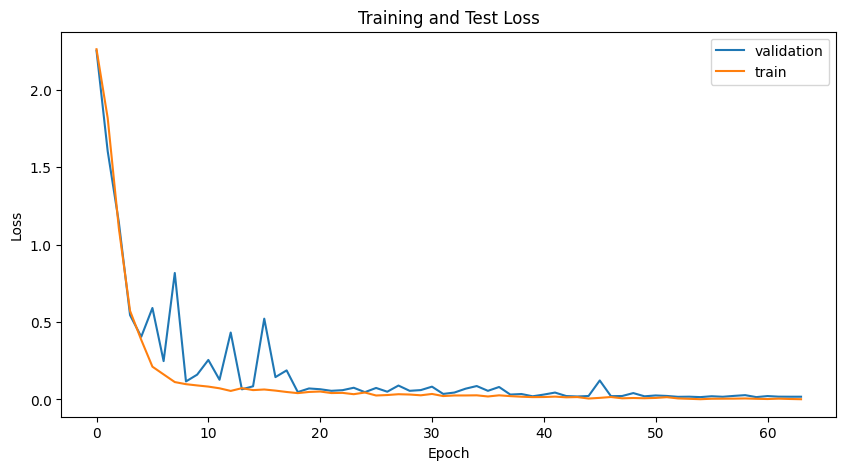

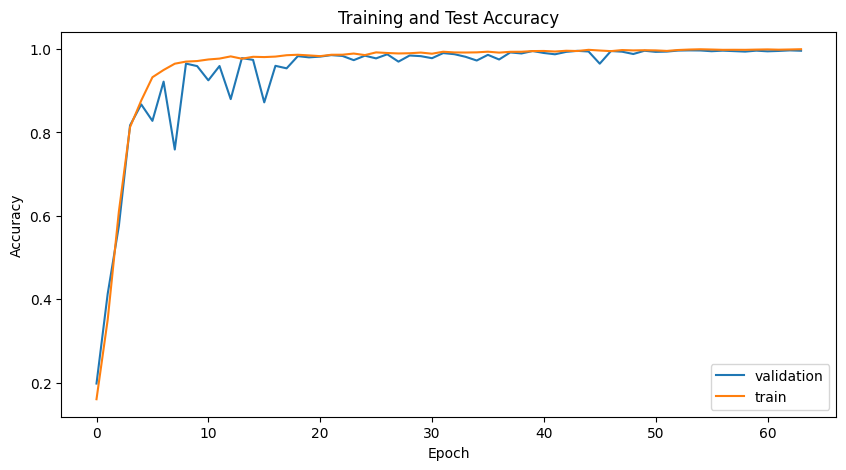

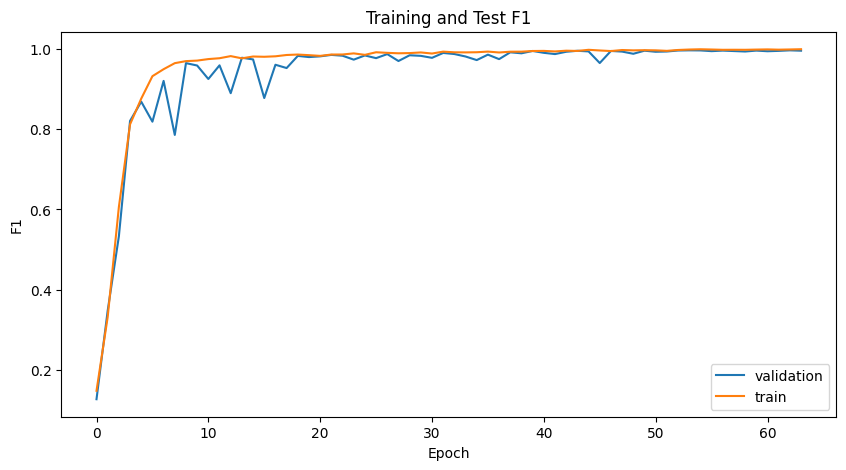

In [14]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [15]:
class CNNInferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [16]:
def cnn_inference(test_loader, model, model_name, config):
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [17]:
test_transformations = val_transforms
test_dataset = CNNInferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = cnn_inference(test_loader, model, model_name, config)

Inference: 100%|██████████| 1246/1246 [04:44<00:00,  4.38it/s]


In [18]:
# resultant csv file
df.to_csv('submission.csv', index=False)